In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile'

from keras import backend as K
from keras.optimizers import Adam

from med_FCN import FCN, FCN_2, FCN_AlexNet
from med_data import generate_arrays_from_file, load_data, distance_mark, load_data_auto_seg
from med_DeconvNetModel import DeconvNet
from med_preprocess import Preprocess 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN not available)


In [9]:
ins = Preprocess("D:/Work/data/2dslice/",number_classes=10)
def train_load(path,model_name="FCN"):
    print "train_load"

    nb_epoch = 20
    batch_size = 10
    learning_rate = 1e-5
    decay_rate = 5e-5
    momentum_rate = 0.9
     
  
    from keras.optimizers import SGD
    sgd = SGD(lr=learning_rate, decay=decay_rate, momentum=momentum_rate, nesterov=True)

    
    smooth =1.


    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        #y_pred_f = K.update(y_pred_f[(y_pred_f >=0.5).nonzero()],1.)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    model_dec = { "FCN" : FCN_2, "DeconvNet" : DeconvNet, "FCN_alex" : FCN_AlexNet}
    model =model_dec[model_name](10)
    
    model.load_weights("weights_of_FCN_alex_ADAM_mask_po6_120_cross.hdf5")
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(lr=5e-6),#'adadelta',
                  metrics=[dice_coef])



    #trains_list,trainl_list = load_data_auto_seg()
    
    
       
    #from keras.callbacks import ModelCheckpoint
    #checkpointer = ModelCheckpoint(filepath="weights_of_FCN_alex_ADAM_mask_po6_19.hdf5", verbose=1, save_best_only=True)
    #print trains_list.shape
    
    history = model.fit_generator(ins.generate_arrays_from_file(),samples_per_epoch=12133,nb_epoch=nb_epoch 
                                 #,callback=[checkpointer]
                                  ,verbose=2
                                  ,validation_data=ins.generate_arrays_from_file(is_train=False),nb_val_samples=3033)
    #history = model.fit(trains_list, trainl_list, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.3, callbacks=[checkpointer])
    model.save_weights("weights_of_FCN_alex_ADAM_mask_po6_160_cross.hdf5")#,by_name=True)
    return model

def load_model(weight_path,model_name="FCN"):
    model_dec = { "FCN" : FCN_2, "DeconvNet" : DeconvNet, "FCN_alex" : FCN_AlexNet}
    model = model_dec[model_name](10)
    
    smooth =1.

    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        #y_pred_f = K.update(y_pred_f[(y_pred_f >=0.5).nonzero()],1.)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    
    model.load_weights(weight_path)
    model.compile(loss=dice_coef_loss,#"categorical_crossentropy",
                  optimizer=Adam(lr=5e-5),#'adadelta',
                  metrics=[dice_coef])
    return model

def predict_data(dataPath, model):
    #output shape (sample, total_pixel, number of classes)
    data_file = ins.load_file(dataPath)
    output = model.predict_on_batch([data_file])
    return output
    

In [10]:
model = train_load('./med_train.txt',model_name="FCN_alex")#"DeconvNet")


train_load
(None, 256, 28, 28)
(None, 256, 14, 14)
(None, 10, 14, 14)
(None, 10, 28, 28)
(None, 50176, 10)
Epoch 1/20
1398s - loss: 0.7428 - dice_coef: 1.2222 - val_loss: 4.2710 - val_dice_coef: 0.9383
Epoch 2/20
1232s - loss: 0.7370 - dice_coef: 1.2231 - val_loss: 4.3343 - val_dice_coef: 0.9381
Epoch 3/20
1236s - loss: 0.7344 - dice_coef: 1.2237 - val_loss: 4.3901 - val_dice_coef: 0.9370
Epoch 4/20
1239s - loss: 0.7329 - dice_coef: 1.2241 - val_loss: 4.3691 - val_dice_coef: 0.9384
Epoch 5/20
1239s - loss: 0.7315 - dice_coef: 1.2244 - val_loss: 4.3434 - val_dice_coef: 0.9408
Epoch 6/20
1234s - loss: 0.7302 - dice_coef: 1.2248 - val_loss: 4.3001 - val_dice_coef: 0.9411
Epoch 7/20
1234s - loss: 0.7290 - dice_coef: 1.2252 - val_loss: 4.2506 - val_dice_coef: 0.9416
Epoch 8/20
1239s - loss: 0.7270 - dice_coef: 1.2257 - val_loss: 4.2128 - val_dice_coef: 0.9420
Epoch 9/20
1240s - loss: 0.7258 - dice_coef: 1.2260 - val_loss: 4.2225 - val_dice_coef: 0.9419
Epoch 10/20
1240s - loss: 0.7240 - dic

(None, 256, 28, 28)
(None, 256, 14, 14)
(None, 10, 14, 14)
(None, 10, 28, 28)
(None, 50176, 10)
(1L, 50176L, 10L)
(None, 256, 28, 28)
(None, 256, 14, 14)
(None, 10, 14, 14)
(None, 10, 28, 28)
(None, 50176, 10)
(1L, 50176L, 10L)


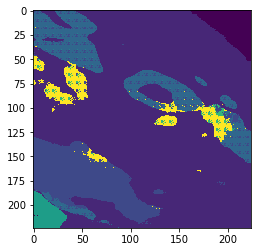

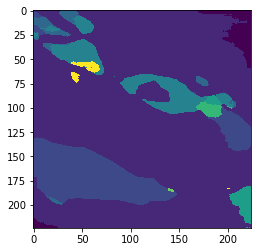

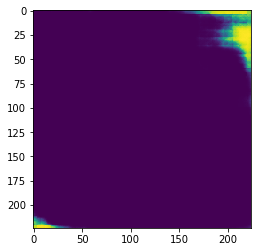

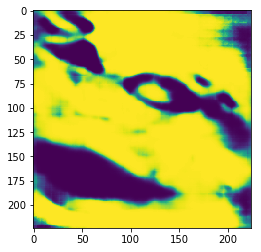

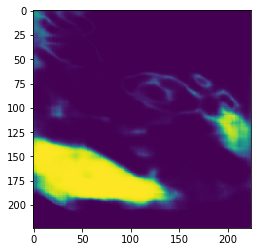

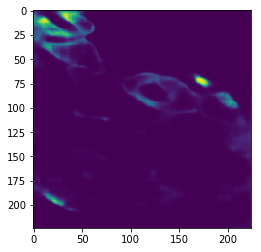

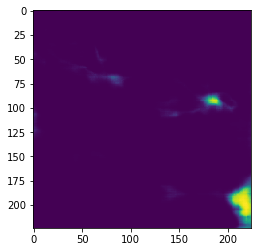

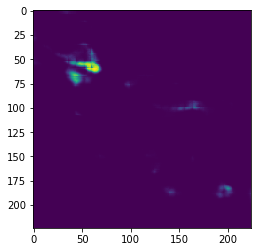

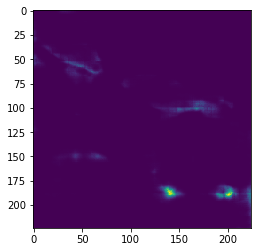

In [8]:
model = load_model("weights_of_FCN_alex_ADAM_mask_po6_160_1.hdf5",model_name="FCN_alex")
result_softmax = predict_data(r'D:\Work\data\2dslice\train_224\5_6_324TEST_tester.png',model)
output_max = np.argmax(result_softmax[0],axis=1).reshape((224,224))
class_map = result_softmax[:,:,8].reshape((224,224))
print result_softmax.shape
plt.show()
plt.imshow(output_max)

model = load_model("weights_of_FCN_alex_ADAM_mask_po6_120_cross.hdf5",model_name="FCN_alex")
result_softmax = predict_data(r'D:\Work\data\2dslice\train_224\5_6_324TEST_tester.png',model)
output_max = np.argmax(result_softmax[0],axis=1).reshape((224,224))
class_map = result_softmax[:,:,8].reshape((224,224))
print result_softmax.shape
plt.show()
plt.imshow(output_max)
class_map = result_softmax[:,:,0].reshape((224,224))
plt.show()
plt.imshow(class_map)
class_map = result_softmax[:,:,1].reshape((224,224))
plt.show()
plt.imshow(class_map)
class_map = result_softmax[:,:,2].reshape((224,224))
plt.show()
plt.imshow(class_map)
class_map = result_softmax[:,:,3].reshape((224,224))
plt.show()
plt.imshow(class_map)
class_map = result_softmax[:,:,4].reshape((224,224))
plt.show()
class_map = result_softmax[:,:,5].reshape((224,224))
plt.show()
plt.imshow(class_map)
class_map = result_softmax[:,:,9].reshape((224,224))
plt.show()
plt.imshow(class_map)
class_map = result_softmax[:,:,8].reshape((224,224))
plt.show()
plt.imshow(class_map)
